# **ERIK SANTANA MONTELONGO**

## **IMPORTAR DATOS Y EXPLORACION BASICA**

In [23]:
import pandas as pd

# Importar los datasets
features_train = pd.read_csv("dengue_features_train.csv")
labels_train = pd.read_csv("dengue_labels_train.csv")
features_test = pd.read_csv("dengue_features_test.csv")
submission_format = pd.read_csv("submission_format.csv")

# valores nulos
print("Valores nulos Features Train: ", features_train.isnull().sum())
print("Valores nulos Labels Train: ", labels_train.isnull().sum())
print("Valores nulos Features Test: ", features_test.isnull().sum())


Valores nulos Features Train:  city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c      

## **PREPROCESAMIENTO DE DATOS**

In [24]:
from sklearn.impute import SimpleImputer

# Eliminar la columna week_start_date
if 'week_start_date' in features_train.columns:
    features_train.drop(columns=['week_start_date'], inplace=True)
    features_test.drop(columns=['week_start_date'], inplace=True)

imputer = SimpleImputer(strategy="mean")
features_train.iloc[:, 3:] = imputer.fit_transform(features_train.iloc[:, 3:])
features_test.iloc[:, 3:] = imputer.transform(features_test.iloc[:, 3:])

# Confirmar que ya no hay valores nulos
print("Valores nulos ahora: ", features_train.isnull().sum().sum())


Valores nulos ahora:  0


In [25]:
from sklearn.preprocessing import LabelEncoder

if 'city' in features_train.columns:
    encoder = LabelEncoder()
    features_train['city'] = encoder.fit_transform(features_train['city'])
    features_test['city'] = encoder.transform(features_test['city'])

print("Valores unicos en city despues de la conversion:", features_train['city'].unique())


Valores unicos en city despues de la conversion: [1 0]


## **SELECCION DE CARACTERISTICAS**

Top 10:
total_cases                  1.000000
reanalysis_min_air_temp_k    0.324776
year                         0.306806
city                         0.292624
reanalysis_tdtr_k            0.278076
station_min_temp_c           0.266227
reanalysis_air_temp_k        0.264564
station_diur_temp_rng_c      0.236552
weekofyear                   0.216452
reanalysis_max_air_temp_k    0.191066
ndvi_ne                      0.157320
Name: total_cases, dtype: float64


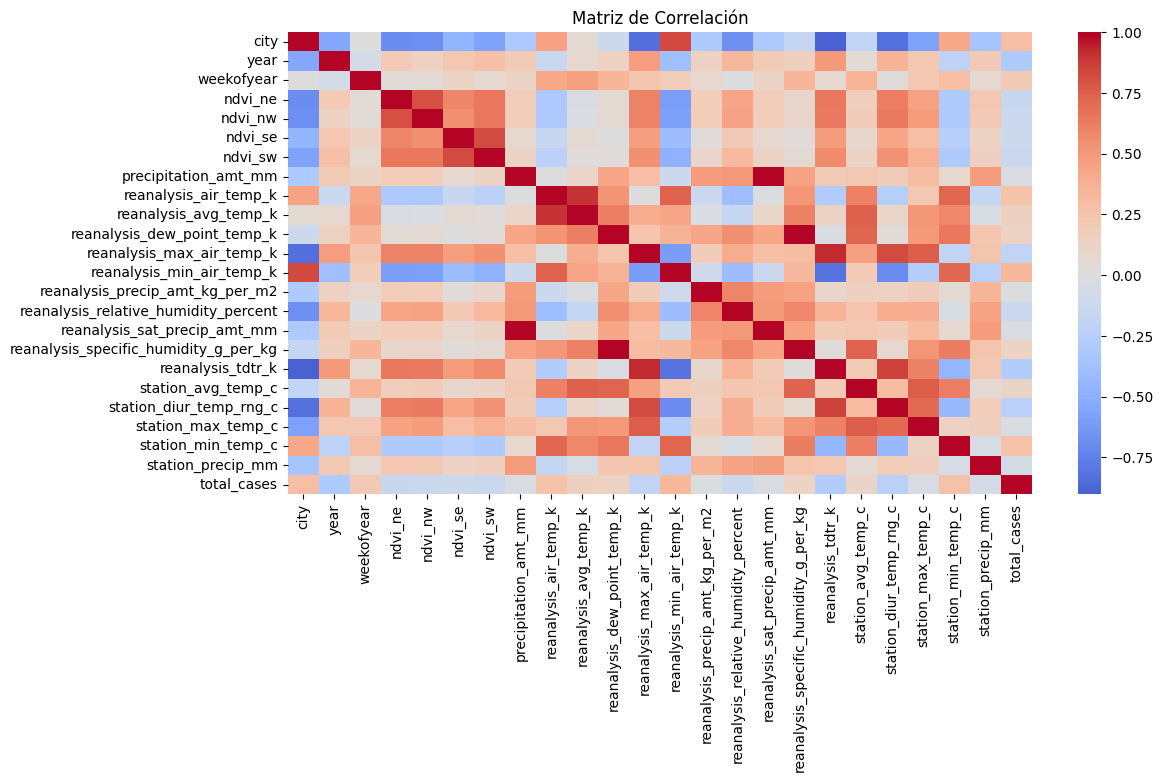

Caracteristicas eliminadas: ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 'station_max_temp_c']
Shape Features Train: (1456, 19)
Shape Features Test: (416, 19)


In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_train = features_train.copy()
df_train["total_cases"] = labels_train["total_cases"]

# Matriz de correlacion
corr_matrix = df_train.corr()

# Mostrar las 10 caracteristicas mas importantes
print("Top 10:")
print(corr_matrix["total_cases"].abs().sort_values(ascending=False).head(11))

# Ver las correlaciones en un heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Matriz de Correlación")
plt.show()

# Eliminar caracteristicas con baja importancia
threshold = 0.05
low_corr_features = corr_matrix["total_cases"].abs()[corr_matrix["total_cases"].abs() < threshold].index
features_train.drop(columns=low_corr_features, inplace=True)
features_test.drop(columns=low_corr_features, inplace=True)

print(f"Caracteristicas eliminadas: {list(low_corr_features)}")
print(f"Shape Features Train: {features_train.shape}")
print(f"Shape Features Test: {features_test.shape}")


## **ENTRENAMIENTO DE MODELOS**

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar features y target
X = features_train.drop(columns=["total_cases"], errors="ignore")
y = labels_train["total_cases"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos para knn
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(features_test)

print(f"Shape entrenamiento: {X_train.shape}")
print(f"Shape validacion: {X_val.shape}")


Shape entrenamiento: (1164, 19)
Shape validacion: (292, 19)


## **NAIVE BAYES**

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error

# Entrenar modelo Naive
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_val)

mae_nb = mean_absolute_error(y_val, y_pred_nb)
print(f"MAE NaiveBayes: {mae_nb}")


MAE NaiveBayes: 31.226027397260275


## **KNN**

In [29]:
from sklearn.neighbors import KNeighborsRegressor

# Entrenar modelo con K=5 (KNN)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_val)

mae_knn = mean_absolute_error(y_val, y_pred_knn)
print(f"MAE KNN: {mae_knn}")


MAE KNN: 19.086301369863016


## **RANDOM FOREST**

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

mae_rf = mean_absolute_error(y_val, y_pred_rf)
print(f"MAE Random Forest: {mae_rf}")


MAE Random Forest: 14.23955479452055


## **HIPERPARAMETRIZACION**

In [31]:
from sklearn.model_selection import GridSearchCV

# Parametros para KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_knn.fit(X_train, y_train)

print(f"Mejor MAE KNN: {-grid_knn.best_score_}")
print(f"Mejores parametros KNN: {grid_knn.best_params_}")


Mejor MAE KNN: 15.887038892566263
Mejores parametros KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [32]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Parametros para Random Forest
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_dist_rf,
                               n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
random_rf.fit(X_train, y_train)

print(f"Mejor MAE Random Forest: {-random_rf.best_score_}")
print(f"Mejores parametros Random Forest: {random_rf.best_params_}")


Mejor MAE Random Forest: 12.559048696031727
Mejores parametros Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}


## **ENTRENAMIENTO DE MODELOS CON LOS MEJORES PARAMETROS**

In [33]:
# Entrenar el modelo KNN con los mejores parámetros
final_knn = KNeighborsRegressor(n_neighbors=9, weights='distance', metric='manhattan')
final_knn.fit(X_train, y_train)

# Predicciones
y_pred_knn_final = final_knn.predict(X_test)

In [34]:
# Entrenar el modelo Random Forest con los mejores parámetros
final_rf = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=2,
                                 max_depth=None, bootstrap=True, random_state=42)
final_rf.fit(X_train, y_train)

# Predicciones
y_pred_rf_final = final_rf.predict(X_test)

In [35]:
# Entrenar el modelo Naive Bayes
final_nb = GaussianNB()
final_nb.fit(X_train, y_train)

# Predicciones
y_pred_nb_final = final_nb.predict(X_test)

## **DESCARGA DE LOS MODELOS**

In [36]:
# Transformar en enteros (Unexpected data types in submission. Expected dtypes: '[dtype('int64')]' Submitted dtypes: '[dtype('float64')]')
y_pred_knn_final = np.round(y_pred_knn_final).astype(int)

# KNN
submission_knn = submission_format.copy()
submission_knn["total_cases"] = y_pred_knn_final
submission_knn.to_csv("submission_knn.csv", index=False)

In [37]:
# Transformar en enteros (Unexpected data types in submission. Expected dtypes: '[dtype('int64')]' Submitted dtypes: '[dtype('float64')]')
y_pred_rf_final = np.round(y_pred_rf_final).astype(int)

# RandomForest
submission_rf = submission_format.copy()
submission_rf["total_cases"] = y_pred_rf_final
submission_rf.to_csv("submission_rf.csv", index=False)

In [38]:
# NaiveBayes
submission_nb = submission_format.copy()
submission_nb["total_cases"] = y_pred_nb_final
submission_nb.to_csv("submission_nb.csv", index=False)